In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
!pip install wget

import wget
import os
import tarfile

if os.path.exists('./eminem_rap_songs.txt'):
  os.unlink('./eminem_rap_songs.txt')
wget.download("https://manojgr-oregon.s3-us-west-2.amazonaws.com/eminem_rap_songs.txt")
os.path.exists('./eminem_rap_songs.txt')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=c338fe95526a113c2eaa47895f0e6cc6db191051e71b4eba347ff44022e6b7e3
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


True

In [0]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow.keras.utils as ku 
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
data = open('./eminem_rap_songs.txt',encoding="utf8").read()

corpus = data.lower().split("\n")

tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)
print(label)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences = True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 19, 100)           144900    
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (N

In [0]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5908 samples
Epoch 1/100
5908/5908 [==============================] - 18s 3ms/sample - loss: 6.7530 - acc: 0.0315
Epoch 2/100
5908/5908 [==============================] - 16s 3ms/sample - loss: 5.9773 - acc: 0.0357
Epoch 3/100
5908/5908 [==============================] - 17s 3ms/sample - loss: 5.7836 - acc: 0.0384
Epoch 4/100
5908/5908 [==============================] - 17s 3ms/sample - loss: 5.6793 - acc: 0.0362
Epoch 5/100
5908/5908 [==============================] - 17s 3ms/sample - loss: 5.5788 - acc: 0.0366
Epoch 6/100
5908/5908 [==============================] - 17s 3ms/sample - loss: 5.4924 - acc: 0.0411
Epoch 7/100
5908/5908 [==============================] - 17s 3ms/sample - loss: 5.4431 - acc: 0.0425
Epoch 8/100
5908/5908 [==============================] - 17s 3ms/sample - loss: 5.3372 - acc: 0.0469
Epoch 9/100
5908/5908 [==============================] - 17s 3ms/sample - lo

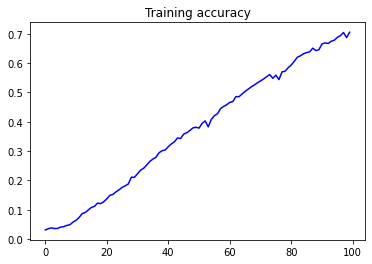

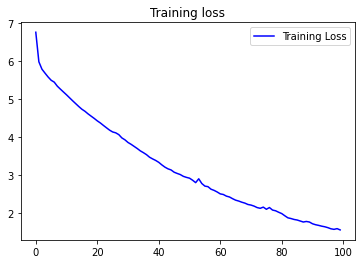

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [0]:
seed_text = "Come along follow me"
next_words = 50

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Come along follow me as i lead through the darkness do the tunnel do sing for the year sing it all and cut my whole world up for my rhyme home to take mommy cd as it seems it important it is mommy crying great rock and rap shittin' for christmas some beef used


# Trying with Keras and Word2Vec

In [0]:
%tensorflow_version 1.x

from __future__ import print_function

import numpy as np
import gensim
import string

from keras.callbacks import LambdaCallback
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Activation
from keras.models import Sequential
from keras.utils.data_utils import get_file

Using TensorFlow backend.


In [0]:
print('\nFetching the text...')
url = 'https://manojgr-oregon.s3-us-west-2.amazonaws.com/eminem_rap_songs.txt'
path = get_file('eminem_rap_songs.txt', origin=url)


Fetching the text...
40960/33992 [====================================] - 0s 3us/step


In [0]:
print('\nPreparing the sentences...')
max_sentence_len = 1000
with open(path) as file_:
  docs = file_.readlines()
sentences = [[word for word in doc.lower().translate(string.punctuation).split()[:max_sentence_len]] for doc in docs]
print('Num sentences:', len(sentences))


Preparing the sentences...
Num sentences: 731


In [0]:
print('\nTraining word2vec...')
word_model = gensim.models.Word2Vec(sentences, size=100, min_count=1, window=5, iter=100)
pretrained_weights = word_model.wv.syn0
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)
print('Checking similar words:')
for word in ['pain', 'success']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) for similar, dist in word_model.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))


Training word2vec...
Result embedding shape: (1779, 100)
Checking similar words:
  pain -> amplified (0.99), earth+ (0.98), plus (0.97), oval (0.97), universe+ (0.97), changed+ (0.97), door (0.97), piling (0.97)
  success -> option, (0.99), failure's (0.98), hotter+ (0.95), monotony's+ (0.95), dad'+ (0.94), nation (0.94), under (0.93), grows (0.93)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [0]:
def word2idx(word):
  return word_model.wv.vocab[word].index
def idx2word(idx):
  return word_model.wv.index2word[idx]

In [0]:
print('\nPreparing the data for LSTM...')
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
train_y = np.zeros([len(sentences)], dtype=np.int32)
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence[:-1]):
    train_x[i, t] = word2idx(word)
  train_y[i] = word2idx(sentence[-1])
print('train_x shape:', train_x.shape)
print('train_y shape:', train_y.shape)


Preparing the data for LSTM...
train_x shape: (731, 1000)
train_y shape: (731,)


In [0]:
print('\nTraining LSTM...')
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, weights=[pretrained_weights]))
model.add(LSTM(units=emdedding_size))
model.add(Dense(units=vocab_size))
model.add(Activation('softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())


Training LSTM...











Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         177900    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 1779)              179679    
_________________________________________________________________
activation_1 (Activation)    (None, 1779)              0         
Total params: 437,979
Trainable params: 437,979
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
def sample(preds, temp=1.0):
  if temp <= 0:
    return np.argmax(preds)
  preds = np.asarray(preds).astype('float64')
  preds = np.log(preds) / temp
  exp_preds = np.exp(preds)
  preds = exp_preds / np.sum(exp_preds)
  proba_sample = np.random.multinomial(1, preds, 1)
  return np.argmax(proba_sample)

def generate_next_words(text, num_generated=50):
  word_idxs = [word2idx(word) for word in text.lower().split()]
  for i in range(num_generated):
    prediction = model.predict(x=np.array(word_idxs))
    idx = sample(prediction[-1], temp=0.7)
    word_idxs.append(idx)
  return ' '.join(idx2word(idx) for idx in word_idxs)

In [0]:
def on_epoch_finish(epoch, _):
  print('\nGenerating text after epoch: %d' % epoch)
  texts = ['Come along follow me']
  for text in texts:
    sample = generate_next_words(text)
    print('%s... -> %s' % (text, sample))

In [0]:
history = model.fit(train_x, train_y,
          batch_size=128,
          epochs=100,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_finish)])



Epoch 1/100
731/731 [==============================] - 11s 15ms/step - loss: 7.4380 - acc: 0.0027

Generating text after epoch: 0
Come along follow me... -> come along follow me systems, playin' almost today+ lifetime+ protectin' strap pitch+ caught mobile mama this right" bar+ new thing, composure+ beginnin', heart+ metamorphosis fans+ causin' name has+ leave hit burn+ fit moment+ mother, booed skeletons are affectin' option, blow+ mobile beyond bothers reality, catch literally cannot worse daddy why of+ gets won't monster,
Epoch 2/100
731/731 [==============================] - 10s 14ms/step - loss: 7.1373 - acc: 0.0123

Generating text after epoch: 1
Come along follow me... -> come along follow me harm shit try+ was means oh leave+ windpipe+ lay career attention decision ready+ deep come happenin'+ dude+ squash won, "you've spaghetti+ nothin'+ world much "i generation+ version"+ pete+ alter squeeze screamin' willing bleeding,"+ knows, instead allows fight, 'em+ her, did, corner plu

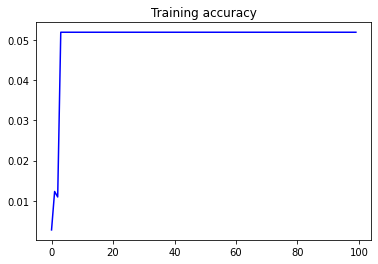

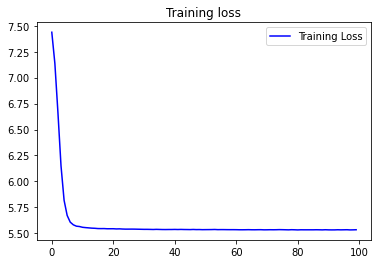

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['acc']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()